[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/qubvel/segmentation_models.pytorch/blob/main/examples/binary_segmentation_intro.ipynb)

🇭 🇪 🇱 🇱 🇴 👋

This example shows how to use `segmentation-models-pytorch` for **binary** semantic segmentation. We will use the [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) (this is an adopted example from Albumentations package [docs](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/), which is strongly recommended to read, especially if you never used this package for augmentations before).

The task will be to classify each pixel of an input image either as pet 🐶🐱 or as a background.


What we are going to overview in this example:  

 - 📜 `Datasets` and `DataLoaders` preparation (with predefined dataset class).  
 - 📦 `LightningModule` preparation: defining training, validation and test routines.  
 - 📈 Writing `IoU` metric inside the `LightningModule` for measuring quality of segmentation.  
 - 🐶 Results visualization.


> It is expected you are familiar with Python, PyTorch and have some experience with training neural networks before!

In [2]:
%%capture
!pip install -U git+https://github.com/qubvel-org/segmentation_models.pytorch
!pip install lightning albumentations

In [3]:
import os

import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader

In [5]:
import numpy as np
from PIL import Image

## Dataset

In this example we will use predefined `Dataset` class for simplicity. The dataset actually read pairs of images and masks from disk and return `sample` - dictionary with keys `image`, `mask` and others (not relevant for this example).

⚠️ **Dataset preparation checklist** ⚠️

In case you writing your own dataset, please, make sure that:

1.   **Images** 🖼  
    ✅   Images from dataset have **the same size**, required for packing images to a batch.  
    ✅   Images height and width are **divisible by 32**. This step is important for segmentation, because almost all models have skip-connections between encoder and decoder and all encoders have 5 downsampling stages (2 ^ 5 = 32). Very likely you will face with error when model will try to concatenate encoder and decoder features if height or width is not divisible by 32.  
    ✅   Images have **correct axes order**. PyTorch works with CHW order, we read images in HWC [height, width, channels], don`t forget to transpose image.
2.   **Masks** 🔳  
    ✅   Masks have **the same sizes** as images.   
    ✅   Masks have only `0` - background and `1` - target class values (for binary segmentation).  
    ✅   Even if mask don`t have channels, you need it. Convert each mask from **HW to 1HW** format for binary segmentation (expand the first dimension).

Some of these checks are included in LightningModule below during the training.

❗️ And the main rule: your train, validation and test sets are not intersects with each other!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [91]:
class POVaDataset(torch.utils.data.Dataset):
    def __init__(self, root, mode="train", transform=None):
        assert mode in {"train", "valid", "test"}

        self.root = root
        self.mode = mode
        self.transform = transform

        self.images_directory = os.path.join(self.root, "images")
        self.masks_directory = os.path.join(self.root, "labels")

        self.files = self._read_split()  # read train/valid splits

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        current_file = self.files[idx]
        # print("current_file", current_file)
        filename = current_file[0]
        extension = current_file[1]
        image_path = os.path.join(self.images_directory, filename + extension)
        mask_path = os.path.join(self.masks_directory, filename + ".png")

        image = np.array(Image.open(image_path).convert("RGB"))

        trimap = np.array(Image.open(mask_path))
        mask = self._preprocess_mask(trimap)

        sample = dict(image=image, mask=mask, trimap=trimap)
        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    @staticmethod
    def _preprocess_mask(mask):
        # mask = mask.astype(np.float32)
        # mask[mask == 2.0] = 0.0
        # mask[(mask == 1.0) | (mask == 3.0)] = 1.0

        # convert from 3-channel to 1-channel
        mask = mask[:, :, 0]
        mask = mask.astype(np.float32)
        mask = mask / 255.0
        return mask

    def _read_split(self):
        files = [(os.path.splitext(f)[0], os.path.splitext(f)[1]) for f in os.listdir(self.images_directory) if f.endswith(('.jpg', '.png'))]
        if self.mode == "train":  # 90% for train
            files = [x for i, x in enumerate(files) if i % 10 != 0]
        elif self.mode == "valid":  # 10% for validation
            files = [x for i, x in enumerate(files) if i % 10 == 0]
        return files

In [92]:
class SimplePOVaDataset(POVaDataset):
    def __getitem__(self, *args, **kwargs):
        sample = super().__getitem__(*args, **kwargs)
        # print("sample", sample)
        # resize images
        image = np.array(
            Image.fromarray(sample["image"]).resize((256, 256), Image.BILINEAR)
        )
        # Image.fromarray(sample["image"]).resize((256, 256), Image.BILINEAR).show()
        # print("image shown")
        mask = np.array(
            Image.fromarray(sample["mask"]).resize((256, 256), Image.NEAREST)
        )

        trimap = np.array(
            Image.fromarray(sample["trimap"]).resize((256, 256), Image.NEAREST)
        )


        # convert to other format HWC -> CHW
        sample["image"] = np.moveaxis(image, -1, 0)
        sample["mask"] = np.expand_dims(mask, 0)
        sample["trimap"] = np.expand_dims(trimap, 0)

        return sample

In [ ]:
# from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

In [15]:
!ls drive/MyDrive/POVa/val_clinic/

images	labels


In [93]:
# load data
root = "drive/MyDrive/POVa/val_clinic/"
train_dataset = SimplePOVaDataset(root, "train")
valid_dataset = SimplePOVaDataset(root, "valid")

In [94]:
type(train_dataset.__getitem__(0))

dict

In [95]:
# init train, val, test sets
# train_dataset = SimpleOxfordPetDataset(root, "train")
# valid_dataset = SimpleOxfordPetDataset(root, "valid")
# test_dataset = SimpleOxfordPetDataset(root, "test")

# It is a good practice to check datasets don`t intersects with each other
# assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
# assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames))
assert set(train_dataset.files).isdisjoint(set(valid_dataset.files))

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
# print(f"Test size: {len(test_dataset)}")

n_cpu = os.cpu_count()
train_dataloader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=n_cpu
)
valid_dataloader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=n_cpu
)
# test_dataloader = DataLoader(
#     test_dataset, batch_size=64, shuffle=False, num_workers=n_cpu
# )

Train size: 550
Valid size: 62


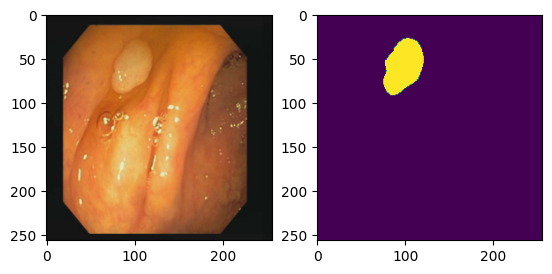

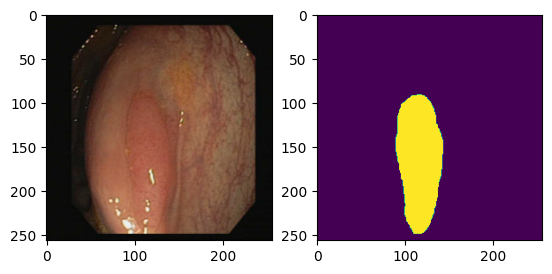

In [96]:
# lets look at some samples

sample = train_dataset[0]
plt.subplot(1, 2, 1)
# for visualization we have to transpose back to HWC
plt.imshow(sample["image"].transpose(1, 2, 0))
plt.subplot(1, 2, 2)
# for visualization we have to remove 3rd dimension of mask
plt.imshow(sample["mask"].squeeze())
plt.show()

sample = valid_dataset[0]
plt.subplot(1, 2, 1)
# for visualization we have to transpose back to HWC
plt.imshow(sample["image"].transpose(1, 2, 0))
plt.subplot(1, 2, 2)
# for visualization we have to remove 3rd dimension of mask
plt.imshow(sample["mask"].squeeze())
plt.show()

# sample = test_dataset[0]
# plt.subplot(1, 2, 1)
# # for visualization we have to transpose back to HWC
# plt.imshow(sample["image"].transpose(1, 2, 0))
# plt.subplot(1, 2, 2)
# # for visualization we have to remove 3rd dimension of mask
# plt.imshow(sample["mask"].squeeze())
# plt.show()

## Model

In [99]:
# Some training hyperparameters
EPOCHS = 10
T_MAX = EPOCHS * len(train_dataloader)
OUT_CLASSES = 1

In [100]:
class POVaModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
        )
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }
        return

In [101]:
model = POVaModel("FPN", "resnet34", in_channels=3, out_classes=1)

## Training

In [102]:
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | FPN      | 23.2 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)
175       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


## Validation and test metrics

In [103]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
print(valid_metrics)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

[{'valid_per_image_iou': 0.8103477358818054, 'valid_dataset_iou': 0.8452724814414978}]


In [ ]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_per_image_iou': 0.9075158834457397, 'test_dataset_iou': 0.9144099950790405}]


# Save model to HF Hub

Login to [HF hub](https://huggingface.co/) if you want to save your model to the hub. Then, you will be able to save and load model, save metrics, and dataset name!

In [104]:
from huggingface_hub import notebook_login

notebook_login()

In [106]:
# get original model from lightning PetModel
smp_model = model.model
# if push_to_hub=True, model will be saved to repository with this name
commit_info = smp_model.save_pretrained(
    save_directory="pova/UNet_clinic_dataset",
    push_to_hub=True,  # optional, push model to HF Hub
    metrics=valid_metrics,  # optional, save metrics in model card
    dataset="POVa Colon",  # optional, save dataset name in model card
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/92.7M [00:00<?, ?B/s]

In [107]:
# Then you can load model from hub
loaded_model = smp.from_pretrained("pova/UNet")
print("Loaded model:", loaded_model.__class__.__name__)

Loading weights from local directory
Loaded model: FPN


# Result visualization

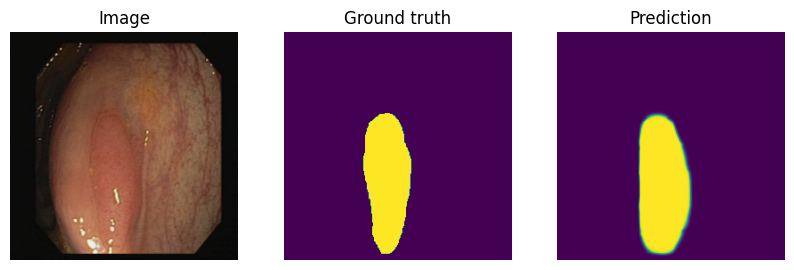

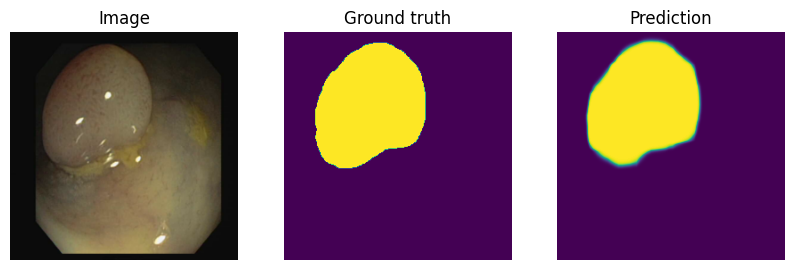

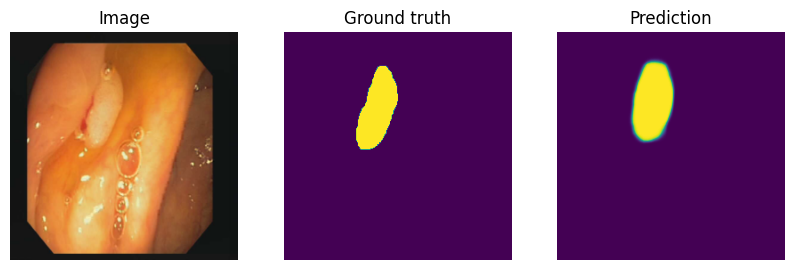

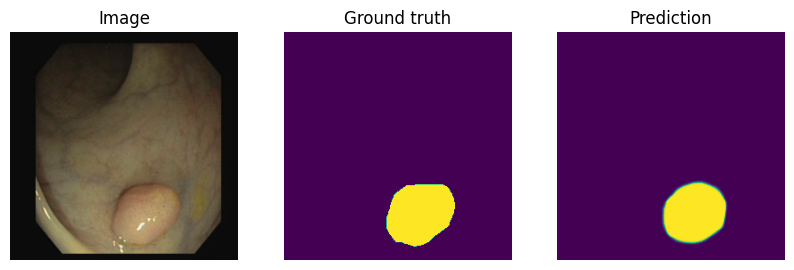

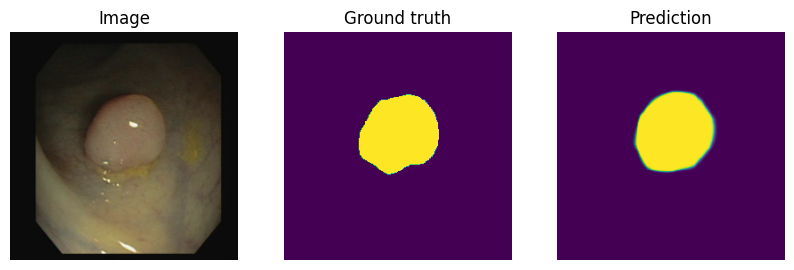

In [108]:
batch = next(iter(valid_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(
    zip(batch["image"], batch["mask"], pr_masks)
):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
    else:
        break